# Modell der hämodynamischen Antwort

### module importieren

In [69]:
import numpy as np
from nilearn import image, input_data, plotting
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from nistats import hemodynamic_models

sns.set_context('poster')

### Dateiname des funktionellen Bildes

In [2]:
epi_file = '../data/sub-01_task-imagery_run-01_bold_space-MNI152NLin2009cAsym_preproc.nii.gz'

In [3]:
epi_file

'../data/sub-01_task-imagery_run-01_bold_space-MNI152NLin2009cAsym_preproc.nii.gz'

### Daten aus Seed extrahieren

Koordinaten der interessierenden Region

In [4]:
my_seeds = [ (0,-50,30) ]

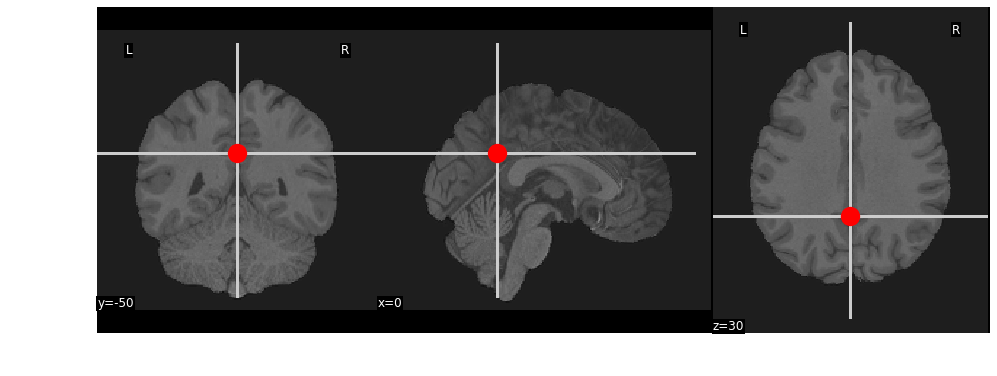

In [70]:
fig,ax = plt.subplots(1,1,figsize=(16,6))
display = plotting.plot_anat('../data/sub-01_T1w_space-MNI152NLin2009cAsym_preproc.nii.gz',
                             cut_coords=my_seeds[-1],
                             axes=ax)
display.add_markers(my_seeds,marker_size=300)
plt.show()

Extraktion der Daten aus der Region

In [6]:
my_standard = True
my_detrend = True
my_smoo = 8

In [7]:
seed_masker = input_data.NiftiSpheresMasker(seeds=my_seeds,
                                            radius=5,
                                            standardize=my_standard,
                                            detrend=my_detrend,
                                            smoothing_fwhm=my_smoo).fit()

In [ ]:
seed_data = seed_masker.transform(epi_file)

seed_df = pd.DataFrame(seed_data)
seed_df.columns = ['signal']

In [9]:
seed_df.tail()

,signal
198,-0.059425
199,-0.599815
200,0.328008
201,-0.028856
202,0.898967


Check: wenn das Detrending funktioniert hat, dann muss der Signalverlauf über alle Volumen hinweg flach sein

In [10]:
linreg_results = stats.linregress(seed_df.index,seed_df['signal'])

In [11]:
print('Schnittpunkt der y-Achse=%.5f\nSteigung der Geraden=%.5f'%(linreg_results.intercept, linreg_results.slope))

Schnittpunkt der y-Achse=-0.00000
Steigung der Geraden=0.00000


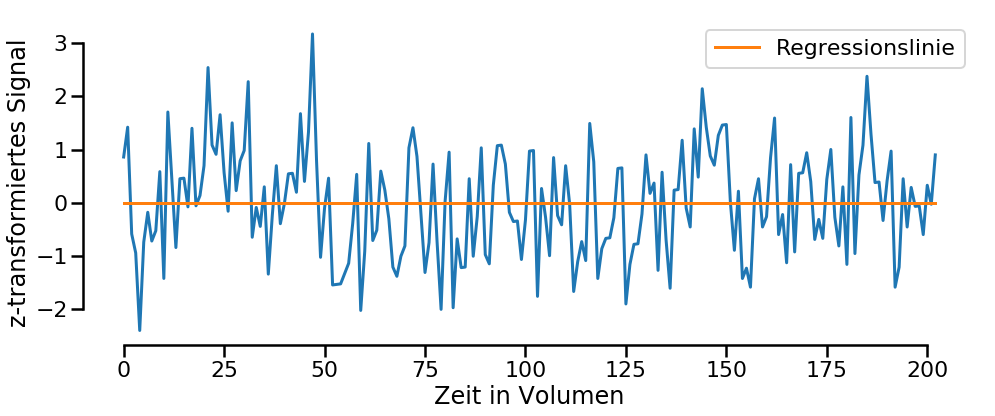

In [12]:
plt.figure(figsize=(16,6))

# die Daten der Seed-Region
plt.plot(seed_df)

# die Ergebnisse der linearen Regression
plt.plot([linreg_results.intercept+linreg_results.slope*x for x in seed_df.index],
         label='Regressionslinie')

plt.ylabel('z-transformiertes Signal')
plt.xlabel('Zeit in Volumen')
plt.legend()
sns.despine(trim=True)
plt.show()

### Studiendesign laden

In [13]:
design_df = pd.read_csv('../data/sub-01_task-imagery_run-01_events.tsv',sep='\t',index_col=[2,4])
design_df = design_df.sort_index()
design_df

onset  duration trial_subdomain
trial_domain trial_content                                    
EMOTION      Klippe              360        30         Negativ
             Strand              450        30         Positiv
             Sturm                90        30         Negativ
             Wald                180        30         Positiv
GESICHTER    Familie             300        30         Bekannt
             Filmschauspieler    210        30        Beruehmt
             Freunde              60        30         Bekannt
             Musiker             480        30        Beruehmt
MOTORIK      Balltreten          150        30          Fuesse
             Fahrrad             510        30          Fuesse
             Jonglieren           30        30          Haende
             Kanu                330        30          Haende
RUHE         Ruhe                120        30            Ruhe
             Ruhe                270        30            Ruhe
             Ruhe                420        30            Ruhe
             Ruhe                570        30            Ruhe
SPRACHE      Lebensmittel        240        30       Schreiben
             Staedte             390        30        Sprechen
             Tiere                 0        30        Sprechen
             Vornamen            540        30       Schreiben

## Modell der hämodynamischen Antwort

In [14]:
my_tr = 3.0
my_onset = 0.0
my_length = 32.0

In [74]:
hrf_model = hemodynamic_models.spm_hrf(tr=my_tr,
                                   oversampling=my_tr,
                                   time_length=my_length+my_onset,
                                   onset=my_onset)

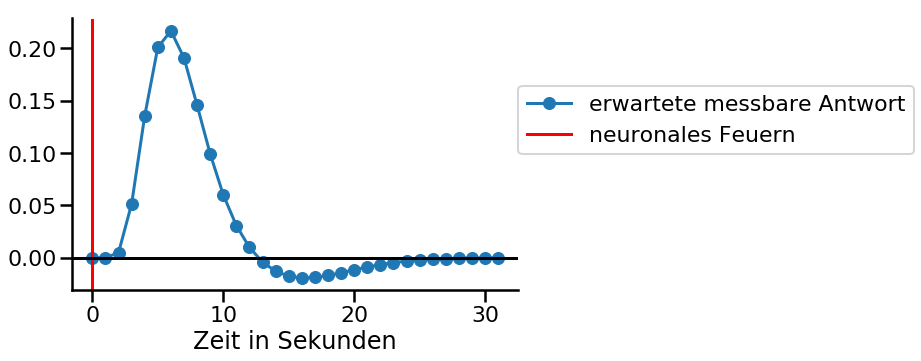

In [16]:
plt.figure(figsize=(8,5))
plt.plot(hrf_model,'-o',label='erwartete messbare Antwort')
plt.axvline(my_onset,color='r',label='neuronales Feuern')
plt.axhline(0,color='k')
sns.despine()
plt.legend(loc=(1,0.5))
plt.xlabel('Zeit in Sekunden')
plt.show()

### Interaktives Verschieben der HRF

In [42]:
from ipywidgets import interact

In [43]:
def f(my_onset):
    hrf_model = hemodynamic_models.spm_hrf(tr=my_tr,
                                       oversampling=my_tr,
                                       time_length=my_length+my_onset,
                                       onset=my_onset)
    plt.figure(figsize=(8,5))
    plt.plot(hrf_model,'-o',label='erwartete messbare Antwort')
    plt.axvline(my_onset,color='r',label='neuronales Feuern')
    plt.axhline(0,color='k')
    sns.despine()
    plt.legend(loc=(1,0.5))
    plt.xlabel('Zeit in Sekunden')
    plt.show()

In [75]:
interact(f,my_onset=(0.0,30.0));

interactive(children=(FloatSlider(value=15.0, description='my_onset', max=30.0), Output()), _dom_classes=('wid…

### Hypothetisches Design

Eine Minute passiert nichts:

In [45]:
beispiel_design = np.zeros(60)
beispiel_design

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.])

Ein Event bei Sekunde 30 hinzufügen

In [46]:
beispiel_design[30] = 1.0

In [47]:
beispiel_design

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.])

Liste mit Events:

In [48]:
event_onsets = np.where(beispiel_design==1)[-1]
event_onsets

array([30])

### Abbildung mit Events und erwarteter Aktivierung

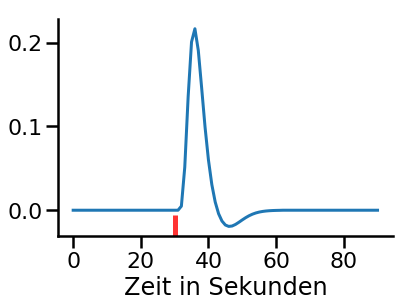

In [50]:
plt.plot(np.convolve(beispiel_design,hrf_model))
sns.rugplot(event_onsets,color='r',height=0.1,linewidth=5,alpha=0.8)
plt.xlabel('Zeit in Sekunden')
sns.despine()
plt.show()

### Noch mehr Events hinzufügen

In [51]:
beispiel_design[3] = 1.0
beispiel_design[33] = 1.0
beispiel_design[34] = 1.0
beispiel_design[45] = 1.0

In [52]:
event_onsets = np.where(beispiel_design==1)[-1]
event_onsets

array([ 3, 30, 33, 34, 45])

### Abbildung die zeigt was passiert, wenn sich HRFs überlappen

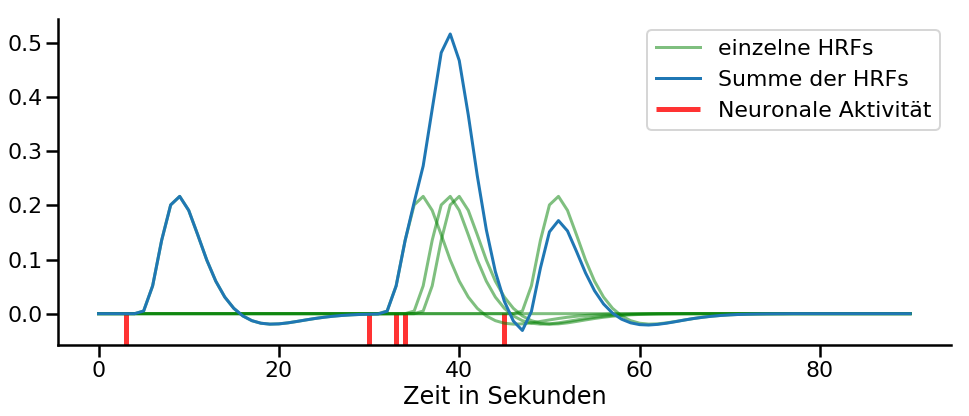

In [53]:
plt.figure(figsize=(16,6))
for event in event_onsets:
    single_hrf = np.zeros(60)
    single_hrf[event] = 1.0
    plt.plot(np.convolve(single_hrf,hrf_model),color='g',alpha=0.5)
plt.plot([],color='g',alpha=0.5,label='einzelne HRFs')
plt.plot(np.convolve(beispiel_design,hrf_model),label='Summe der HRFs')
sns.rugplot(event_onsets,color='r',height=0.1,linewidth=5,alpha=0.8,label='Neuronale Aktivität')
plt.legend(loc='best')
plt.xlabel('Zeit in Sekunden')
sns.despine()
plt.show()

### Design der Studie modellieren

Anzahl der Volumen in der Zeitserie

In [54]:
number_of_volumes = image.load_img(epi_file).shape[-1]
number_of_volumes

203

Zeit in Sekunden = Anzahl Volumen x TR

In [56]:
beispiel_design = np.zeros(int(number_of_volumes*my_tr))
beispiel_design.shape[-1]

609

Onsets und Duration der Ruhebedingung

In [57]:
ruhe_onsets = design_df.loc['RUHE',['onset','duration']]
ruhe_onsets

,onset,duration
trial_content,,
Ruhe,120,30
Ruhe,270,30
Ruhe,420,30
Ruhe,570,30


Alle Onsets einer Bedingung

In [58]:
def make_onsets(df,number_of_volumes=number_of_volumes,my_tr=my_tr):
    design = np.zeros(int(number_of_volumes*my_tr))
    # für jede Zeile in der Tabelle
    for start in range(df.shape[0]):
        # Inhalte der Zeile
        block = df.iloc[start]
        # Onsets und Durations extrahieren
        block_onset = block['onset']
        block_duration = block['duration']
        # Ab Onset so viele 1en einfügen wie der Block lang ist
        for event in range(block_duration):
            design[block_onset+event] = 1.
    return design

In [59]:
beispiel_design = make_onsets(ruhe_onsets)

In [60]:
beispiel_design

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

Original An/Aus Design (Boxcar) oder mit HRF verbunden

In [63]:
boxcar_design_in_tr = beispiel_design[::int(my_tr)]
boxcar_design_in_tr

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.])

In [65]:
hrf_design_in_tr = np.convolve(beispiel_design,hrf_model)[::int(my_tr)]

### Abbildung mit Daten und Modellen

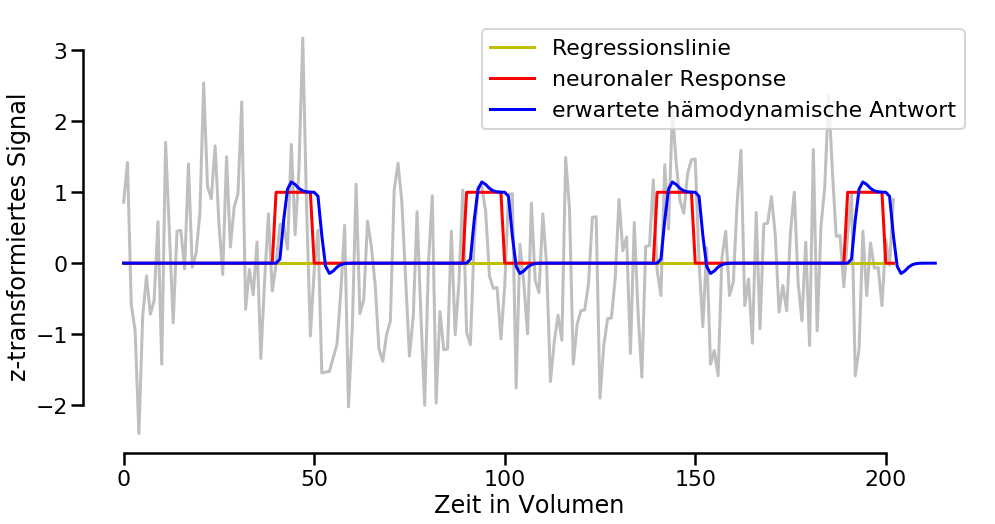

In [66]:
plt.figure(figsize=(16,8))

# die Daten der Seed-Region
plt.plot(seed_df,color='grey',alpha=0.5)
# die Ergebnisse der linearen Regression
plt.plot([linreg_results.intercept+linreg_results.slope*x for x in seed_df.index],
         label='Regressionslinie',color='y')

# ein-aus-Design
plt.plot(boxcar_design_in_tr,color='r',label='neuronaler Response')
# HRF-Design
plt.plot(hrf_design_in_tr,'b',label='erwartete hämodynamische Antwort')

plt.legend(loc='best')

plt.ylabel('z-transformiertes Signal')
plt.xlabel('Zeit in Volumen')
sns.despine(trim=True)
plt.show()

### Korrelation Daten mit Design

In [67]:
seed_df.corrwith(pd.Series(boxcar_design))

signal    0.174355
dtype: float64

In [68]:
seed_df.corrwith(pd.Series(hrf_design))

signal    0.236496
dtype: float64